In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from glob import glob
import pandas as pd
import pickle
from torch.utils.data import RandomSampler
import random
import scipy
import torch.nn.functional as F
from PIL import Image
from glob import glob
import sys
sys.path.append('../../modified_medsam_repo')
from MedSAM_HCP.dataset import MRIDataset_Imgs, load_datasets, LabelConverter
from MedSAM_HCP.utils_hcp import show_mask, show_box

In [2]:
def read_format_table(path, read_gt = False):
    IMG_WIDTH = 256
    IMG_HEIGHT = 256
    if read_gt:
        cols = ['class', 'x_center', 'y_center', 'width', 'height']
    else:
        cols = ['class', 'x_center', 'y_center', 'width', 'height', 'confidence']
    df = pd.read_csv(path, delimiter=' ', header=None, names=cols)
    df = df.sort_values('class').reset_index(drop=True)
    df['x_center'] = (df['x_center'] * IMG_WIDTH)
    df['y_center'] = (df['y_center'] * IMG_HEIGHT)
    df['width'] = (df['width'] * IMG_WIDTH)
    df['height'] = (df['height'] * IMG_HEIGHT)

    return df
def yolov7_format_to_bbox_format(x_center, y_center, width, height):
    x0 = x_center - width / 2.0
    y0 = y_center - height / 2.0

    x1 = x_center + width / 2.0
    y1 = y_center + height / 2.0

    return x0, y0, x1, y1

def extract_box_np_from_df(df, label):
    row = df.loc[df['class'] == label]
    if len(row) == 0:
        return np.full((4,), np.nan)
    if len(row)>1:
        print(row)
    box = np.array(yolov7_format_to_bbox_format(row['x_center'].item(), 
                                      row['y_center'].item(),
                                      row['width'].item(), 
                                      row['height'].item()))
    return box

def run_tag(collect_lists, root_dir, tag='train', conf_thresh = 0.225, force_stop = None):
    
    for ix, file in enumerate(tqdm(sorted(glob(f'{root_dir}/{tag}_run/labels/*.txt')))):
        if force_stop is not None and ix >= force_stop:
            break
        basename = os.path.basename(file)
        id_num = int(basename.split('_')[0])
        slice_num = int(basename.split('_slice')[-1].split('.txt')[0])
        dfo = read_format_table(file, read_gt=False)
        dfo = dfo[dfo['confidence'] >= conf_thresh]
        dfo = dfo.sort_values('confidence').drop_duplicates('class', keep='last')    
        dfo['bbox_0'] = (dfo['x_center'] - dfo['width']/2.0).round().astype(int)
        dfo['bbox_1'] = (dfo['y_center'] - dfo['height']/2.0).round().astype(int)
        dfo['bbox_2'] = (dfo['x_center'] + dfo['width']/2.0).round().astype(int)
        dfo['bbox_3'] = (dfo['y_center'] + dfo['height']/2.0).round().astype(int)


        for i, r in dfo.iterrows():
            if r['class']==0:
                continue
            ans = np.array([id_num, slice_num, r['bbox_0'], r['bbox_1'], r['bbox_2'], r['bbox_3']]).astype(int)
            collect_lists[int(r["class"])].append(ans)
    
    return collect_lists
    
def merge_collect_lists(collect_lists, label):
    ori_df = pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/path_df_unet.csv')
    this_class_df = pd.DataFrame(collect_lists[label], columns = ['id', 'slice', 'bbox_0', 'bbox_1', 'bbox_2', 'bbox_3'])
    merged = ori_df.merge(this_class_df, how = 'right', on = ['id', 'slice'])
    return merged

def run_medsam_tag(collect_lists, root_dir, tag='train', force_stop = None):
    for ix, file in enumerate(tqdm(sorted(glob(f'{root_dir}/{tag}_run/labels/*.txt')))):
        if force_stop is not None and ix >= force_stop:
            break
        basename = os.path.basename(file)
        id_num = int(basename.split('_')[0])
        slice_num = int(basename.split('_slice')[-1].split('.txt')[0])
        arr = np.load(f'/gpfs/data/luilab/karthik/pediatric_seg_proj/saved_round1_segmentations_bbox/{id_num}/{slice_num}.npy')
        arr = arr[:, [0,2,1,3]]
        masker = np.any(np.isnan(arr), axis=1)
        for i in range(arr.shape[0]):
            if i==0:
                continue
            if masker[i] == True: # NAN's here
                continue
            ans = np.array([id_num, slice_num, arr[i,0], arr[i,1], arr[i,2], arr[i,3]]).astype(int)
            collect_lists[i].append(ans)
    
    return collect_lists

In [24]:
collect_lists_medsam = []
for i in range(NUM_CLASSES):
    collect_lists_medsam.append([])
true_lens = sum([len(x) for x in run_medsam_tag(collect_lists_medsam, 'train', force_stop=10000)][1:])
print(f'medsam bboxes have total calls ~{true_lens}')

  4%|▍         | 10000/228096 [00:10<03:51, 943.58it/s]


In [41]:
print(f'medsam bboxes have total calls ~{true_lens}')

medsam bboxes have total calls ~139977


In [38]:
NUM_CLASSES = 103
collect_lists = []
for i in range(NUM_CLASSES):
    collect_lists.append([])
ret = run_tag(collect_lists, root_dir='/gpfs/data/luilab/karthik/pediatric_seg_proj/yolov10_results/0.1', 
    tag='val', conf_thresh = 0, force_stop = 10000000)

100%|██████████| 28416/28416 [08:04<00:00, 58.59it/s]


In [87]:
gen_df = merge_collect_lists(ret, 58)
gen_df = gen_df.sort_values(['id', 'slice']).reset_index()
gen_df

,index,id,slice,img_slice_path,segmentation_slice_path,bbox_0,bbox_1,bbox_2,bbox_3
0,0,102109,124,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,150,158,173,181
1,1,102109,125,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,150,158,176,183
2,2,102109,133,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,142,158,175,185
3,3,102109,134,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,142,158,176,186
4,4,102109,135,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,150,157,177,185
...,...,...,...,...,...,...,...,...,...
3677,3677,994273,204,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,158,168,177,176
3678,3678,994273,205,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,162,158,177,169
3679,3679,994273,206,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,160,160,177,170
3680,3680,994273,207,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,161,159,177,169


107321_159


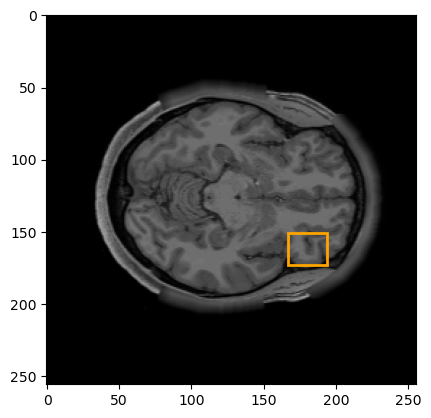

In [116]:

df_hcp = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/hcp_mapping_processed.csv')
df_desired = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/darts_name_class_mapping_processed.csv')
label_converter = LabelConverter(df_hcp, df_desired)
ds = MRIDataset_Imgs(gen_df, label_id=58, label_converter=label_converter, NUM_CLASSES=2)

def show_slice(ds, row_idx):
    #id = df.iloc[row_idx, 0]
    #sli = df.iloc[row_idx, 1]
    print(ds.get_slice_name(row_idx))

    img, seg = ds[row_idx]
    img, seg = img.numpy(), seg.numpy()
    img = np.transpose(img, (1,2,0)) / 255.0
    fig, ax = plt.subplots()    
    ax.imshow(img)
    show_mask(seg, ax, random_color=False)
    show_box((ds.data_frame.loc[row_idx, 'bbox_0'],
                ds.data_frame.loc[row_idx, 'bbox_1'],
                ds.data_frame.loc[row_idx, 'bbox_2'],
                ds.data_frame.loc[row_idx, 'bbox_3']
    ), ax, color='orange')

show_slice(ds, 86)

In [4]:
print(sum([len(x) for x in ret][1:]))

18812


In [5]:
print(sum([len(x) for x in ret][1:]))

10564


In [28]:
print(sum([len(x) for x in ret][1:]))
print(sum([len(x) for x in ret2][1:]))

107843
96480


In [38]:
collect_lists_yolov7 = []
for i in range(NUM_CLASSES):
    collect_lists_yolov7.append([])

yolov7_lens_15 = run_tag(collect_lists_yolov7, tag='train', conf_thresh = 0.15, force_stop = 10000)

collect_lists_yolov7 = []
for i in range(NUM_CLASSES):
    collect_lists_yolov7.append([])

yolov7_lens_20 = run_tag(collect_lists_yolov7, tag='train', conf_thresh = 0.2, force_stop = 10000)

collect_lists_yolov7 = []
for i in range(NUM_CLASSES):
    collect_lists_yolov7.append([])

yolov7_lens_225 = run_tag(collect_lists_yolov7, tag='train', conf_thresh = 0.225, force_stop = 10000)

collect_lists_yolov7 = []
for i in range(NUM_CLASSES):
    collect_lists_yolov7.append([])

yolov7_lens_25 = run_tag(collect_lists_yolov7, tag='train', conf_thresh = 0.25, force_stop = 10000)

collect_lists_yolov7 = []
for i in range(NUM_CLASSES):
    collect_lists_yolov7.append([])

yolov7_lens_30 = run_tag(collect_lists_yolov7, tag='train', conf_thresh = 0.30, force_stop = 10000)

  4%|▍         | 10000/228096 [00:56<20:42, 175.50it/s]


In [42]:
collect_lists_yolov7 = []
for i in range(NUM_CLASSES):
    collect_lists_yolov7.append([])

yolov7_lens_175 = run_tag(collect_lists_yolov7, tag='train', conf_thresh = 0.175, force_stop = 10000)

  4%|▍         | 10000/228096 [01:10<25:38, 141.78it/s]


In [43]:
print(sum([len(x) for x in yolov7_lens_15][1:]))
print(sum([len(x) for x in yolov7_lens_175][1:]))
print(sum([len(x) for x in yolov7_lens_20][1:]))
print(sum([len(x) for x in yolov7_lens_225][1:]))
print(sum([len(x) for x in yolov7_lens_25][1:]))
print(sum([len(x) for x in yolov7_lens_30][1:]))

140427
138651
137050
135502
134049
131120


In [5]:
NUM_CLASSES=103
conf_thresh = 0.225
collect_lists = []
for i in range(NUM_CLASSES):
    collect_lists.append([])

collect_lists = run_tag(collect_lists, 'train', conf_thresh, )
collect_lists = run_tag(collect_lists, 'val', conf_thresh, )
collect_lists = run_tag(collect_lists, 'test', conf_thresh)

  1%|          | 1281/228096 [00:18<55:40, 67.91it/s]  


KeyboardInterrupt: 

In [ ]:
ori_df = pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/path_df.csv')
for class_num in range(1, NUM_CLASSES):
    this_class_df = pd.DataFrame(collect_lists[class_num], columns = ['id', 'slice', 'bbox_0', 'bbox_1', 'bbox_2', 'bbox_3'])
    merged = ori_df.merge(this_class_df, how = 'right', on = ['id', 'slice'])

    save_path = os.path.join('/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df/yolov7', f'path_df_label{class_num}_only_with_bbox_yolov7.csv')
    merged.to_csv(save_path)
